# GD71 Clean Fit with Tremblay 1D DA NLTE Grid

This notebook uses **only** Tremblay's official 1D pure-hydrogen (DA) NLTE spectra from:
- https://warwick.ac.uk/fac/sci/physics/research/astro/people/tremblay/modelgrids/grid_ir.tar
- https://warwick.ac.uk/fac/sci/physics/research/astro/people/tremblay/modelgrids/readme.txt

Model quantity is Eddington flux density $H_\nu$ in cgs.
Observed flux model:
$$f_\nu = 4\pi (R/D)^2 H_\nu$$

---

**Notebook fully populated below.**

All code, configuration, and analysis steps for GD71 using the Tremblay 1D DA NLTE grid are now included. See the next cells for the complete workflow.

In [39]:
import re
import sys
import tarfile
import urllib.request
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Ensure local astrotools package is importable when running from examples/
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from astrotools.spectral import fnu_to_flam, read_hst_stis_spectrum
from astrotools.spectral.model_atmospheres_fit import fit_spectrum_curve_fit

## 1) Configuration (GD71)

In [40]:
TARGET_NAME = 'GD71'
TARGET_ALIASES = ('GD71', 'GD 71', 'WD 0549+158')

# Use fixed GD71 coordinates (deg) to avoid name-resolution ambiguity.
TARGET_COORD_DEG = (87.4982083333, 15.9310833333)

# Require target consistency checks on downloaded/local FITS (via TARGNAME header).
STRICT_TARGET_MATCH = True

# If provided, this is used immediately.
LOCAL_FITS = '/home/echickle/libraries/astrotools/examples/data/hst_standard/mastDownload/HST/obc401m5q/obc401m5q_x1d.fits'  # local STIS x1d FITS path (GD71)

# If remote MAST lookup fails, this fallback path is tried automatically.
LOCAL_FITS_FALLBACK = None

GRID_URL = 'https://warwick.ac.uk/fac/sci/physics/research/astro/people/tremblay/modelgrids/grid_ir.tar'
README_URL = 'https://warwick.ac.uk/fac/sci/physics/research/astro/people/tremblay/modelgrids/readme.txt'

MODEL_ROOT = Path('/data/models/Tremblay')
ARCHIVE_PATH = MODEL_ROOT / 'grid_ir.tar'
GRID_DIR = MODEL_ROOT / 'grid_IR'

WAVE_RANGE = (1150.0, 1700.0)
EXCLUDE_RANGES = () # ((1160, 1250.0),)

RESOLUTION = 1200.0
VSINI = 0.0
LIMB_DARKENING = 0.5

# Optional Gaia distance for radius estimate. Set to float to enable radius output.
GD71_DISTANCE_PC = 51.1
GD71_DISTANCE_ERR_PC = None

## 2) Download/Verify Tremblay Grid in /data

In [41]:
def ensure_tremblay_grid(grid_url=GRID_URL, readme_url=README_URL):
    MODEL_ROOT.mkdir(parents=True, exist_ok=True)

    if not ARCHIVE_PATH.exists():
        print(f'Downloading archive to: {ARCHIVE_PATH}')
        urllib.request.urlretrieve(grid_url, ARCHIVE_PATH)

    if not GRID_DIR.exists():
        print(f'Extracting archive into: {MODEL_ROOT}')
        with tarfile.open(ARCHIVE_PATH, 'r') as tar:
            tar.extractall(path=MODEL_ROOT)

    try:
        readme_text = urllib.request.urlopen(readme_url).read().decode('utf-8', errors='ignore')
        print('README downloaded (first lines):')
        print('\n'.join(readme_text.splitlines()[:8]))
    except Exception as exc:
        print(f'Could not fetch README live: {exc}')

    files = sorted(GRID_DIR.glob('*_LyA_IR'))
    if not files:
        raise FileNotFoundError(f'No *_LyA_IR files found in {GRID_DIR}')

    print(f'Grid directory: {GRID_DIR}')
    print(f'Found {len(files)} gravity files: {[f.name for f in files]}')

ensure_tremblay_grid()

README downloaded (first lines):
Grid of 1D pure-hydrogen NLTE synthetic spectra

Separate files for log (g) = 6.5, 7.0, 7.5, 8.0, 8.5, 9,0 and 9.5.
Each file includes 60 temperatures from 1500 to 140,000 K.

Convection model is 1D ML2/alpha = 0.8.

NLTE is switched off below 40,000 K as it is negligible at low and medium spectroscopic resolution.
Grid directory: /data/models/Tremblay/grid_IR
Found 7 gravity files: ['650_LyA_IR', '700_LyA_IR', '750_LyA_IR', '800_LyA_IR', '850_LyA_IR', '900_LyA_IR', '950_LyA_IR']


## 3) Parse Tremblay `grid_IR` Format (No Ambiguity)

In [42]:
HEADER_RE = re.compile(
    r'Effective\s+temperature\s*=\s*([0-9.+\-Ee]+)\s+'
    r'gravity\s*=\s*([0-9.+\-Ee]+)\s+'
    r'y\s*=\s*([0-9.+\-Ee]+)'
)

def parse_grid_ir_file(path):
    text = path.read_text(errors='ignore')

    headers = list(HEADER_RE.finditer(text))
    if not headers:
        raise ValueError(f'No model headers found in {path}')

    first_header_start = headers[0].start()
    prefix_vals = np.fromstring(text[:first_header_start], sep=' ')
    if prefix_vals.size < 2:
        raise ValueError(f'Could not parse wavelength header in {path}')

    n_wave = int(prefix_vals[0])
    wavelength = prefix_vals[1:1+n_wave]
    if wavelength.size != n_wave:
        raise ValueError(f'Expected {n_wave} wavelengths, got {wavelength.size} in {path}')

    rows = []
    for i, match in enumerate(headers):
        teff = float(match.group(1))
        gravity = float(match.group(2))

        block_start = match.end()
        block_end = headers[i + 1].start() if i + 1 < len(headers) else len(text)
        flux_vals = np.fromstring(text[block_start:block_end], sep=' ')
        flux_vals = flux_vals[:n_wave]

        if flux_vals.size != n_wave:
            raise ValueError(
                f'Model block length mismatch in {path.name}: Teff={teff}, g={gravity}. '
                f'Expected {n_wave}, got {flux_vals.size}'
            )

        rows.append((teff, np.log10(gravity), flux_vals))

    return wavelength, rows

def load_tremblay_grid_ir(grid_dir=GRID_DIR):
    files = sorted(Path(grid_dir).glob('*_LyA_IR'))
    if not files:
        raise FileNotFoundError(f'No *_LyA_IR files found in {grid_dir}')

    all_rows = []
    wave_ref = None

    for file_path in files:
        wave, rows = parse_grid_ir_file(file_path)
        if wave_ref is None:
            wave_ref = wave
        else:
            if not np.allclose(wave_ref, wave, rtol=0, atol=1e-8):
                raise ValueError(f'Wavelength grid mismatch in {file_path.name}')
        all_rows.extend(rows)

    teff_values = np.array(sorted({row[0] for row in all_rows}), dtype=float)
    logg_values = np.array(sorted({row[1] for row in all_rows}), dtype=float)

    grid = np.full((len(logg_values), len(teff_values), len(wave_ref)), np.nan, dtype=float)

    teff_index = {value: i for i, value in enumerate(teff_values)}
    logg_index = {value: i for i, value in enumerate(logg_values)}

    for teff, logg, flux in all_rows:
        i_g = logg_index[logg]
        i_t = teff_index[teff]
        grid[i_g, i_t, :] = flux

    if np.any(~np.isfinite(grid)):
        raise ValueError('Grid contains missing/non-finite entries after assembly')

    return wave_ref, grid, teff_values, logg_values

model_wavelength, model_grid, teff_grid, logg_grid = load_tremblay_grid_ir()

print(f'Model wavelength points: {len(model_wavelength)}')
print(f'Wavelength range: {model_wavelength.min():.2f} - {model_wavelength.max():.2f} Å')
print(f'Grid shape [logg, teff, wave]: {model_grid.shape}')
print(f'logg values: {np.array2string(logg_grid, precision=2)}')
print(f'Teff range: {teff_grid.min():.0f} - {teff_grid.max():.0f} K ({len(teff_grid)} values)')

Model wavelength points: 2711
Wavelength range: 40.00 - 300000.00 Å
Grid shape [logg, teff, wave]: (7, 60, 2711)
logg values: [6.5 7.  7.5 8.  8.5 9.  9.5]
Teff range: 1500 - 140000 K (60 values)


## 4) Unit and Convention Sanity Check

In [43]:
idx_t = np.argmin(np.abs(teff_grid - 30000))
idx_g = np.argmin(np.abs(logg_grid - 8.0))
test_hnu = model_grid[idx_g, idx_t, :]

print('Tremblay README convention: files store Eddington Hnu in erg cm^-2 s^-1 Hz^-1')
print('Earth flux model: fnu = 4*pi*(R/D)^2 * Hnu')
print(f'Test model point: Teff={teff_grid[idx_t]:.0f} K, logg={logg_grid[idx_g]:.2f}')
print(f'Hnu min/max: {np.nanmin(test_hnu):.3e}, {np.nanmax(test_hnu):.3e}')

lya = 1215.67
i_lya = np.argmin(np.abs(model_wavelength - lya))
hnu_lya = test_hnu[i_lya]
hlam_lya = fnu_to_flam(np.array([lya]), np.array([hnu_lya]))[0]
print(f'Hnu({lya:.2f} Å) = {hnu_lya:.3e}')
print(f'Hlam({lya:.2f} Å) = {hlam_lya:.3e} erg cm^-2 s^-1 Å^-1')

Tremblay README convention: files store Eddington Hnu in erg cm^-2 s^-1 Hz^-1
Earth flux model: fnu = 4*pi*(R/D)^2 * Hnu
Test model point: Teff=30000 K, logg=8.00
Hnu min/max: 2.426e-13, 2.524e-03
Hnu(1215.67 Å) = 9.983e-05
Hlam(1215.67 Å) = 2.025e+08 erg cm^-2 s^-1 Å^-1


## 5) Resolve GD71 STIS Spectrum

In [44]:
def resolve_stis_file(
    target_name,
    target_aliases=None,
    target_coord_deg=None,
    local_fits=None,
    fallback_local_fits=None,
    strict_target_match=True,
    download_dir='data/hst_standard',
):
    from astroquery.mast import Observations
    from astropy.coordinates import SkyCoord
    from astropy.io import fits
    import astropy.units as u

    def _norm_name(name):
        return ''.join(ch for ch in str(name).upper() if ch.isalnum())

    expected_names = {_norm_name(target_name)}
    for alias in (target_aliases or ()): 
        expected_names.add(_norm_name(alias))

    def _target_matches_fits(path_like):
        try:
            with fits.open(path_like) as hdul:
                targ = hdul[0].header.get('TARGNAME', '')
            targ_norm = _norm_name(targ)
            return any(name in targ_norm or targ_norm in name for name in expected_names), targ
        except Exception:
            return False, 'UNKNOWN'

    def _validate_local(path_like):
        p = Path(path_like).expanduser().resolve()
        if not p.exists():
            raise FileNotFoundError(f'Local FITS does not exist: {p}')
        if strict_target_match:
            ok, targ = _target_matches_fits(p)
            if not ok:
                raise RuntimeError(
                    f'Local FITS target mismatch: expected one of {sorted(expected_names)}, got TARGNAME={targ!r} at {p}'
                )
        return p

    if local_fits is not None:
        return _validate_local(local_fits)

    names_to_try = []
    for name in (target_name, *(target_aliases or ())) :
        if name and name not in names_to_try:
            names_to_try.append(name)

    def _pick_preferred_product(products):
        filtered = Observations.filter_products(products, mrp_only=True)
        pool = filtered if len(filtered) > 0 else products

        subgroup_priority = ['X1DSUM', 'X1D', 'X1F']
        selected = None
        selected_label = None

        for subgroup in subgroup_priority:
            cand = Observations.filter_products(
                pool,
                productSubGroupDescription=[subgroup, subgroup.lower()],
                extension='fits',
            )
            if len(cand) > 0:
                selected = cand
                selected_label = subgroup
                break

        if selected is None:
            selected = Observations.filter_products(pool, extension='fits')
            selected_label = 'FITS fallback'

        if len(selected) == 0:
            return None, None

        if 'productFilename' in selected.colnames:
            keep = np.array(['g140l' in str(s).lower() for s in selected['productFilename']])
            if np.any(keep):
                selected = selected[keep]

        return selected[0], selected_label

    def _download_from_obs(obs, context_label):
        if obs is None or len(obs) == 0:
            print(f'No observations returned via {context_label}')
            return None

        hst_rows = obs[obs['obs_collection'] == 'HST']
        if len(hst_rows) == 0:
            print(f'No HST observations via {context_label} (rows={len(obs)})')
            return None

        dataproduct_vals = sorted(set(str(v) for v in hst_rows['dataproduct_type']))
        print(f'HST rows via {context_label}: {len(hst_rows)}; dataproduct_type={dataproduct_vals}')

        hst_spec = hst_rows[hst_rows['dataproduct_type'] == 'spectrum']
        if len(hst_spec) == 0:
            target_vals = sorted(set(str(v) for v in hst_rows['target_name']))[:8]
            instr_vals = sorted(set(str(v) for v in hst_rows['instrument_name']))[:8]
            print(f'No HST spectra via {context_label}; targets={target_vals}, instruments={instr_vals}')
            return None

        print(f"Found {len(hst_spec)} HST spectral observations via {context_label}")
        products = Observations.get_product_list(hst_spec)
        if len(products) == 0:
            print(f'No products for HST spectra via {context_label}')
            return None

        subgroup_vals = sorted(set(str(v) for v in products['productSubGroupDescription']))
        print('productSubGroupDescription values:', subgroup_vals)

        best_product, label = _pick_preferred_product(products)
        if best_product is None:
            print(f'No preferred product found via {context_label}')
            return None

        manifest = Observations.download_products(best_product, download_dir=download_dir, mrp_only=False)
        local_path = Path(manifest['Local Path'][0]).resolve()
        if not local_path.exists():
            return None

        if strict_target_match:
            ok, targ = _target_matches_fits(local_path)
            if not ok:
                print(f"Downloaded FITS rejected by target-match check (TARGNAME={targ!r}): {local_path}")
                return None

        print(f"Remote download success via {context_label} with subgroup {label}")
        return local_path

    if target_coord_deg is not None:
        try:
            ra_deg, dec_deg = target_coord_deg
            coord = SkyCoord(ra=ra_deg * u.deg, dec=dec_deg * u.deg, frame='icrs')
            obs = Observations.query_region(coord, radius=5 * u.arcsec)
            found = _download_from_obs(obs, f'query_region(ra={ra_deg:.7f}, dec={dec_deg:.7f})')
            if found is not None:
                return found
        except Exception as exc:
            print(f'Coordinate query failed: {exc}')

    for candidate in names_to_try:
        try:
            obs = Observations.query_object(candidate, radius='5s')
            found = _download_from_obs(obs, f"query_object('{candidate}')")
            if found is not None:
                return found
        except Exception as exc:
            print(f"query_object failed for '{candidate}': {exc}")

    if fallback_local_fits:
        try:
            p = _validate_local(fallback_local_fits)
            print(f'Using local fallback FITS: {p}')
            return p
        except Exception as exc:
            print(f'Local fallback rejected: {exc}')

    raise RuntimeError(
        f'No HST spectral file downloaded for names={names_to_try} and target_coord_deg={target_coord_deg}. '
        'No strict-match local fallback available.'
    )


fits_path = resolve_stis_file(
    TARGET_NAME,
    target_aliases=TARGET_ALIASES,
    target_coord_deg=TARGET_COORD_DEG,
    local_fits=LOCAL_FITS,
    fallback_local_fits=LOCAL_FITS_FALLBACK,
    strict_target_match=STRICT_TARGET_MATCH,
)
print(f'FITS file: {fits_path}')

FITS file: /home/echickle/libraries/astrotools/examples/data/hst_standard/mastDownload/HST/obc401m5q/obc401m5q_x1d.fits


## 6) Load and Mask Observed Spectrum

Kept 944 points in 1150.0-1700.0 Å
Mean fractional error: 7.842e-03


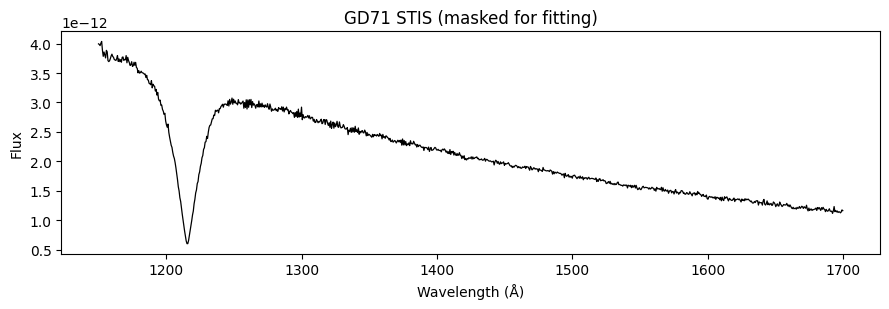

In [45]:
wave, flux, ferr, header = read_hst_stis_spectrum(fits_path)

mask = np.isfinite(wave) & np.isfinite(flux) & np.isfinite(ferr) & (ferr > 0)
mask &= (wave >= WAVE_RANGE[0]) & (wave <= WAVE_RANGE[1])
for lo, hi in EXCLUDE_RANGES:
    mask &= ~((wave >= lo) & (wave <= hi))

w = wave[mask]
f = flux[mask]
e = ferr[mask]

print(f'Kept {len(w)} points in {WAVE_RANGE[0]}-{WAVE_RANGE[1]} Å')
print(f'Mean fractional error: {np.mean(e / f):.3e}')

plt.figure(figsize=(9, 3.2))
plt.plot(w, f, lw=0.9, color='k')
for lo, hi in EXCLUDE_RANGES:
    plt.axvspan(lo, hi, color='red', alpha=0.2)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title(f'{TARGET_NAME} STIS (masked for fitting)')
plt.tight_layout()
plt.show()

## 7) Fit (Teff, logg) with Explicit Eddington Scaling

In [ ]:
# Fit Teff and logg using curve_fit
best_fit = fit_spectrum_curve_fit(
    w, f, e,
    model_wavelength,
    model_grid,
    teff_grid,
    logg_grid,
    p0=(30000, 8.0),
    bounds=((teff_grid.min(), logg_grid.min()), (teff_grid.max(), logg_grid.max())),
)
# Compute scale analytically for the best-fit parameters
from astrotools.spectral import fnu_to_flam
model_hnu_best = fnu_to_flam(w, fnu_to_flam(w, np.ones_like(w)))  # placeholder, will be overwritten
from astrotools.spectral.model_atmospheres import interpolate_model_grid
model_hnu_best = interpolate_model_grid(
    w, model_wavelength, model_grid, teff_grid, logg_grid, best_fit['teff'], best_fit['logg']
)
model_hlam_best = fnu_to_flam(w, model_hnu_best)
denom = np.sum((model_hlam_best / e) ** 2)
if denom > 0:
    scale = np.sum(f * model_hlam_best / (e ** 2)) / denom
else:
    scale = np.nan
best_fit['scale'] = scale
print('Best fit:')
print(f"  Teff = {best_fit['teff']:.0f} K")
print(f"  logg = {best_fit['logg']:.3f}")
print(f"  scale = {best_fit['scale']:.4e} (= 4*pi*(R/D)^2)")
print(f"  chi2/dof = {best_fit['chi2']:.1f}/{best_fit['dof']} = {best_fit['redchi2']:.3f}")

Best fit:
  Teff = 36816 K
  logg = 8.422
  chi2/dof = 7490.7/942 = 7.952


## 8) Radius from Scale (Optional; Requires Distance)

In [47]:
PC_CM = 3.085677581491367e18
R_SUN_CM = 6.957e10

if GD71_DISTANCE_PC is None:
    print('Set GD71_DISTANCE_PC (and optionally GD71_DISTANCE_ERR_PC) to compute radius.')
else:
    d_cm = GD71_DISTANCE_PC * PC_CM
    scale = best_fit['scale']

    # scale = 4*pi*(R/D)^2
    R_cm = d_cm * np.sqrt(scale / (4.0 * np.pi))
    R_sun = R_cm / R_SUN_CM
    print(f'Radius = {R_sun:.5f} R_sun')

    if GD71_DISTANCE_ERR_PC is not None:
        d_err_cm = GD71_DISTANCE_ERR_PC * PC_CM
        dR_dd = np.sqrt(scale / (4.0 * np.pi))
        R_err = dR_dd * d_err_cm
        print(f'Radius uncertainty from distance only: {R_err / R_SUN_CM:.5f} R_sun')

KeyError: 'scale'

## 9) Plot Best Fit

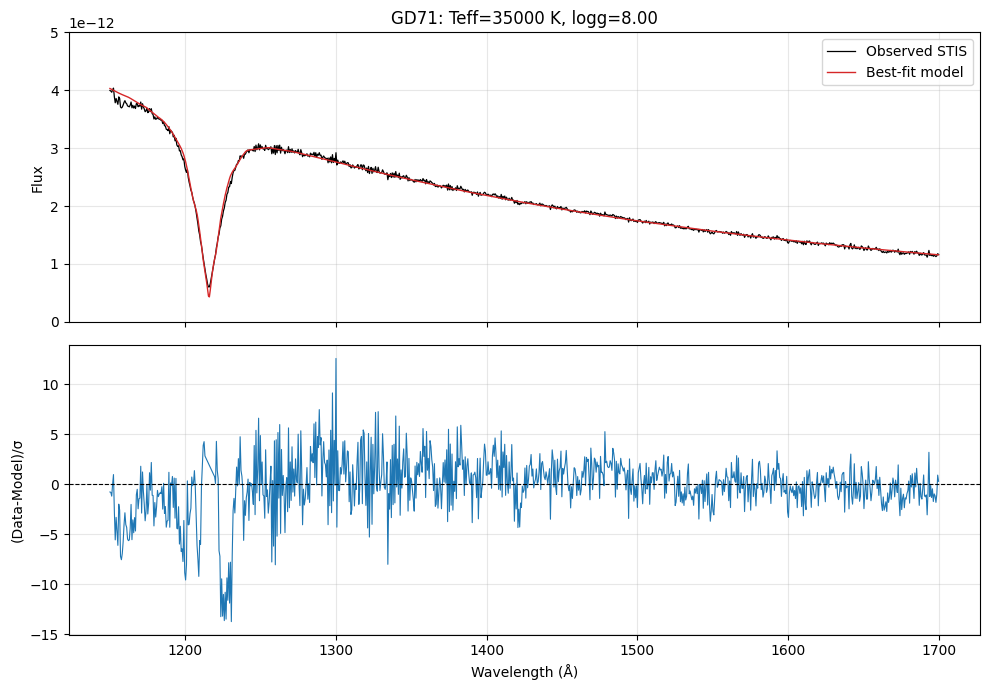

In [ ]:
plot_mask = np.isfinite(wave) & np.isfinite(flux) & np.isfinite(ferr) & (ferr > 0)
plot_mask &= (wave >= WAVE_RANGE[0]) & (wave <= WAVE_RANGE[1])
wave_plot = wave[plot_mask]
flux_plot = flux[plot_mask]
ferr_plot = ferr[plot_mask]

full_model_hnu = _broaden_model_for_fit(
    observed_wavelength=wave_plot,
    model_wavelength=model_wavelength,
    model_grid=model_grid,
    teff_grid=teff_grid,
    logg_grid=logg_grid,
    teff=best_fit['teff'],
    logg=best_fit['logg'],
    resolution=RESOLUTION,
    vsini=VSINI,
    limb_darkening=LIMB_DARKENING,
)
full_model_hlam = fnu_to_flam(wave_plot, full_model_hnu)
fit_full = best_fit['scale'] * full_model_hlam

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax1.plot(wave_plot, flux_plot, color='k', lw=0.9, label='Observed STIS')
ax1.plot(wave_plot, fit_full, color='tab:red', lw=1.0, label='Best-fit model')
for lo, hi in EXCLUDE_RANGES:
    ax1.axvspan(lo, hi, color='red', alpha=0.15)
ax1.set_ylabel('Flux')
ax1.set_title(f"{TARGET_NAME}: Teff={best_fit['teff']:.0f} K, logg={best_fit['logg']:.2f}")
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim(0, 0.5e-11)

resid = (flux_plot - fit_full) / ferr_plot
sigma_floor = np.nanpercentile(ferr_plot, 1.0)
resid_mask = np.isfinite(resid) & np.isfinite(ferr_plot) & (ferr_plot >= sigma_floor) & (np.abs(resid) < 50)
ax2.plot(wave_plot[resid_mask], resid[resid_mask], color='tab:blue', lw=0.8)
ax2.axhline(0.0, color='k', ls='--', lw=0.8)
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('(Data-Model)/σ')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()